In [1]:
import pandas as pd
import numpy as np
import datetime
from skmisc.loess import loess
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("../data/raw/louisville_line_data.csv")

In [4]:
df.head()

AGECAT  CONGESTION CVD19VAC PPLHM      RECORD_ID ROUNDNAME SECTOR VACDT1  \
0       3         NaN      NaN     1  primary-11617     r1vol     3B    NaN   
1       2         NaN      NaN     1  primary-11884     r1vol     4B    NaN   
2       1         NaN      NaN     3  primary-13039     r1vol     2B    NaN   
3       2         NaN      NaN     1  primary-13042     r1vol     4B    NaN   
4       1         NaN      NaN     5  primary-13043     r1vol     3B    NaN   

   HC___1  HC___2  ...  RACE  CGH          BGID     APDATETIME  ZIPCODE  CVCT  \
0     0.0     0.0  ...   1.0  2.0  2.111101e+11            NaN  40291.0   0.0   
1     0.0     0.0  ...   1.0  2.0  2.111101e+11  6/13/20 16:30  40242.0   0.0   
2     0.0     0.0  ...   1.0  2.0  2.111101e+11  6/12/20 11:15  40205.0   0.0   
3     0.0     0.0  ...   2.0  2.0           NaN   6/13/20 9:15      NaN   0.0   
4     0.0     0.0  ...   2.0  2.0  2.111101e+11  6/13/20 10:00  40219.0   0.0   

   PPLHM_N  NIGG  SIGG         TRACT  
0      1.0   NaN   NaN  2.111101e+10  
1      1.0   NaN   NaN  2.111101e+10  
2      3.0   NaN   NaN  2.111101e+10  
3      1.0   NaN   NaN           NaN  
4      5.0   NaN   NaN  2.111101e+10  

[5 rows x 41 columns]

In [5]:
df.shape

(11046, 41)

# Volunteer plot

In [7]:
df = pd.read_csv("../data/raw/louisville_line_data.csv")

In [8]:
df["IS_VOL"] = [ df.ROUNDNAME.iloc[i].endswith("vol") if not pd.isna(df.ROUNDNAME.iloc[i]) else \
              None for i in range(df.shape[0])]
df["CVD19VAC"] = [ ans if ans=="Yes" else "No" for ans in list(df["CVD19VAC"])]
df["DATE"] = [ pd.to_datetime(date).date() for date in df.APDATETIME]

In [9]:
df = df[df.DATE<pd.to_datetime("2021-04-13").date()]

In [10]:
df_plot = df[["IS_VOL", "CVD19VAC", "DATE"]].groupby(["IS_VOL", "CVD19VAC", "DATE"]).size().reset_index().sort_values("DATE")
df_plot = df_plot.dropna()
df_plot = df_plot.merge(df[["ROUNDNAME", "DATE"]].drop_duplicates(), on="DATE", how="inner")
df_plot["ROUNDNAME"] = [wave[1] for wave in df_plot.ROUNDNAME]
df_plot = df_plot.drop_duplicates()

In [11]:
dates = list(df_plot.DATE)
df_temp = df_plot[(df_plot.IS_VOL==0) & (df_plot.CVD19VAC=="Yes")]
yes0 = [ df_temp.iloc[list(df_temp.DATE).index(date), 3] \
      if date in list(df_temp.DATE) else 0
      for date in dates ]
df_temp = df_plot[(df_plot.IS_VOL==1) & (df_plot.CVD19VAC=="Yes")]
yes1 = [ df_temp.iloc[list(df_temp.DATE).index(date), 3] \
      if date in list(df_temp.DATE) else 0
      for date in dates ]
df_temp = df_plot[(df_plot.IS_VOL==0) & (df_plot.CVD19VAC=="No")]
no0 = [ df_temp.iloc[list(df_temp.DATE).index(date), 3] \
      if date in list(df_temp.DATE) else 0
      for date in dates ]
df_temp = df_plot[(df_plot.IS_VOL==1) & (df_plot.CVD19VAC=="No")]
no1 = [ df_temp.iloc[list(df_temp.DATE).index(date), 3] \
      if date in list(df_temp.DATE) else 0
      for date in dates ]

In [12]:
bar_width = 0.5
bg_alpha = 0.08

df_temp = df_plot[["DATE", "ROUNDNAME"]].drop_duplicates()
wave_breaks =[-.5] + [ i for i in range(1, df_temp.shape[0]) if df_temp.ROUNDNAME.iloc[i-1]!=df_temp.ROUNDNAME.iloc[i]] + [df_temp.shape[0]+0.5]

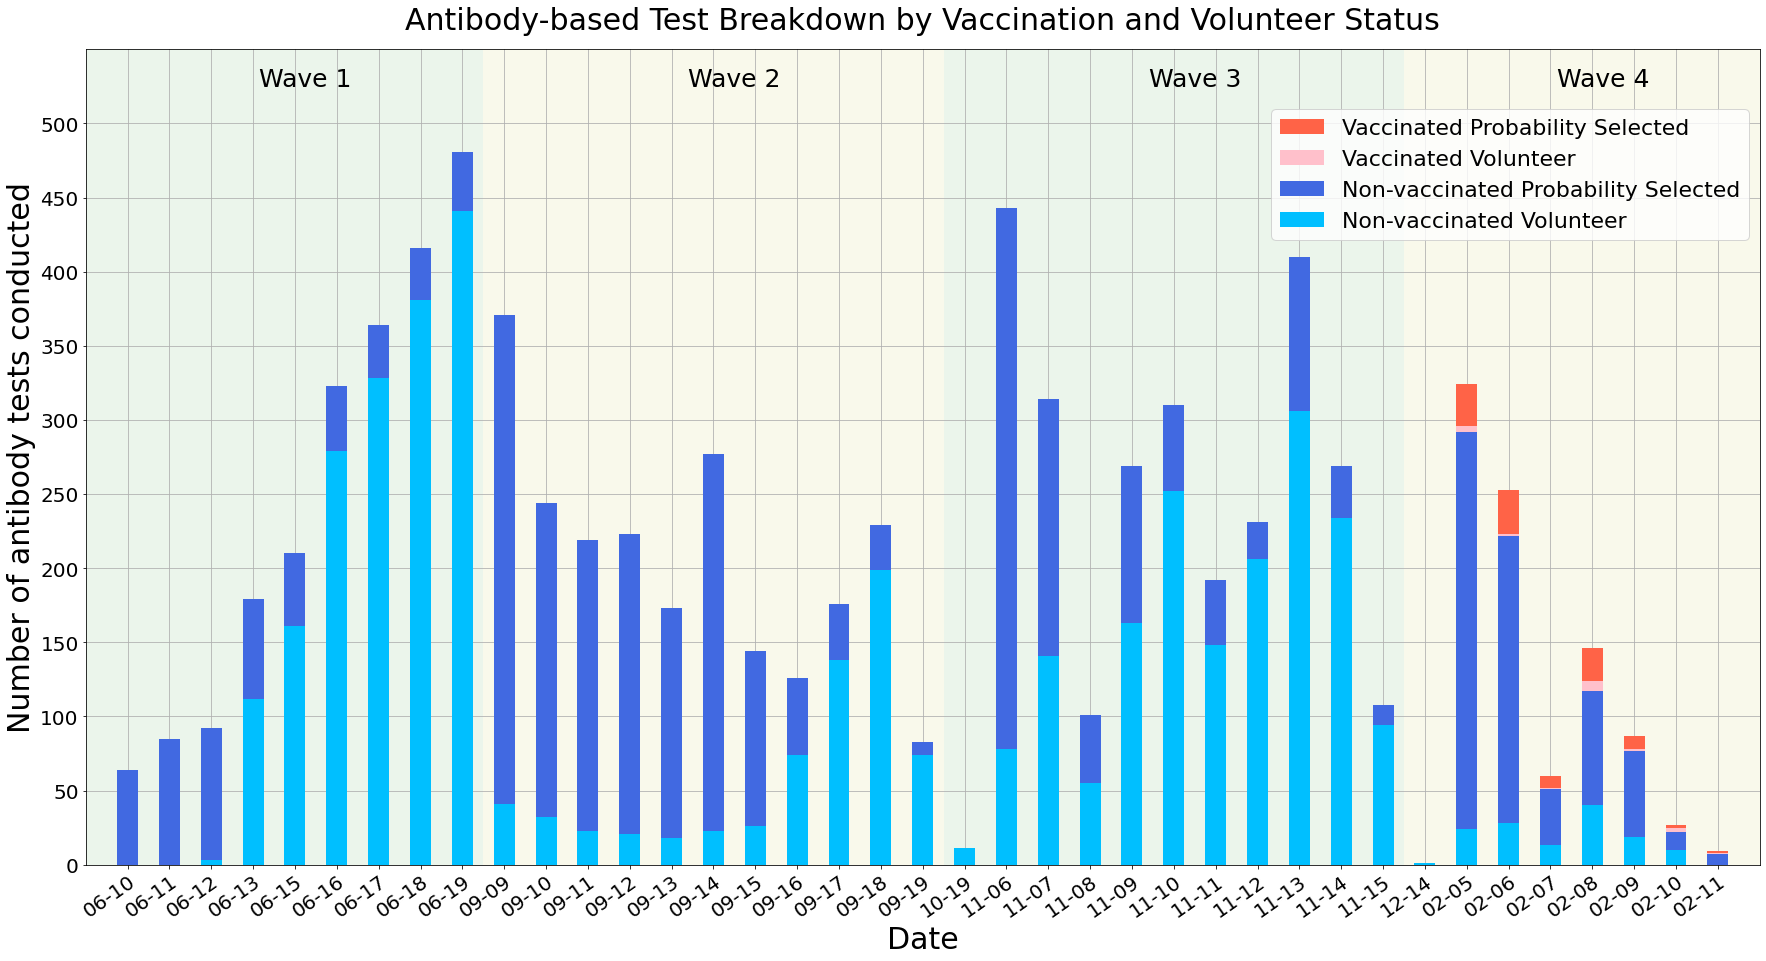

In [14]:
fig, ax = plt.subplots(figsize=(30,15))
fig.canvas.draw()

plt.xticks(rotation = 35, fontsize=20)
plt.yticks(np.arange(0,550,50), fontsize=20)

for i in range(len(wave_breaks)-1):
    if i%2:
        ax.axvspan(wave_breaks[i]-0.5, wave_breaks[i+1]-0.5, facecolor='y', alpha=bg_alpha, label='_nolegend_')
    else:
        ax.axvspan(wave_breaks[i]-0.5, wave_breaks[i+1]-0.5, facecolor='g', alpha=bg_alpha, label='_nolegend_')
    ax.text((wave_breaks[i]+wave_breaks[i+1])/2, 525, "Wave "+str(i+1), 
            fontsize=25, horizontalalignment="center")
    
ax.grid(zorder=0)
ax.bar([str(d) for d in dates], yes0, bottom=[yes1[i]+no1[i]+no0[i] for i in range(len(dates))], 
       color='tomato', width=bar_width, zorder=3, label="Vaccinated Probability Selected")
ax.bar([str(d) for d in dates], yes1, bottom=[no1[i]+no0[i] for i in range(len(dates))], 
       color='pink', width=bar_width, zorder=3, label="Vaccinated Volunteer")
ax.bar([str(d) for d in dates], no0, bottom=no1, 
       color='royalblue', width=bar_width, zorder=3, label="Non-vaccinated Probability Selected")
ax.bar([str(d) for d in dates], no1, 
       color='deepskyblue', width=bar_width, zorder=3, label="Non-vaccinated Volunteer")


ax.xaxis.set_ticks(range(len(np.unique(dates))))
ax.set_xticklabels([str(d)[5:] for d in np.unique(dates)], ha='right', rotation_mode='anchor')
ax.set_ylim((0,550))
ax.legend(fontsize=22, loc="upper right", bbox_to_anchor=(1, 0.94))
ax.set_title("Antibody-based Test Breakdown by Vaccination and Volunteer Status", fontsize=30, y=1.0, pad=20)
plt.xlabel("Date", fontsize=30)
plt.ylabel("Number of antibody tests conducted", fontsize=30)
plt.margins(0.0)
# plt.savefig('histogram_w1-4.png')
plt.show()

# Dot plot

In [2]:
path = "../results/temp/"
# df_prev = pd.read_csv(path+"I_estimate_zone_1_w1-4.csv")
# df_point = pd.read_csv(path+"data_zone_5_w1-4.csv")
df_prev = pd.read_csv(path+"I_estimate_msd_01_w1-4.csv")
df_point = pd.read_csv(path+"data_msd_01_w1-4.csv")


In [3]:
xticks_span = 75
max_y1 = 0.007
max_y2 = 0.35
water_div = 21000
xtick_vals = np.arange(0, df_prev.shape[0]/2, xticks_span/2)
star_sizes = [(size/2+10)**2 for size in df_point.num_antibody_total]

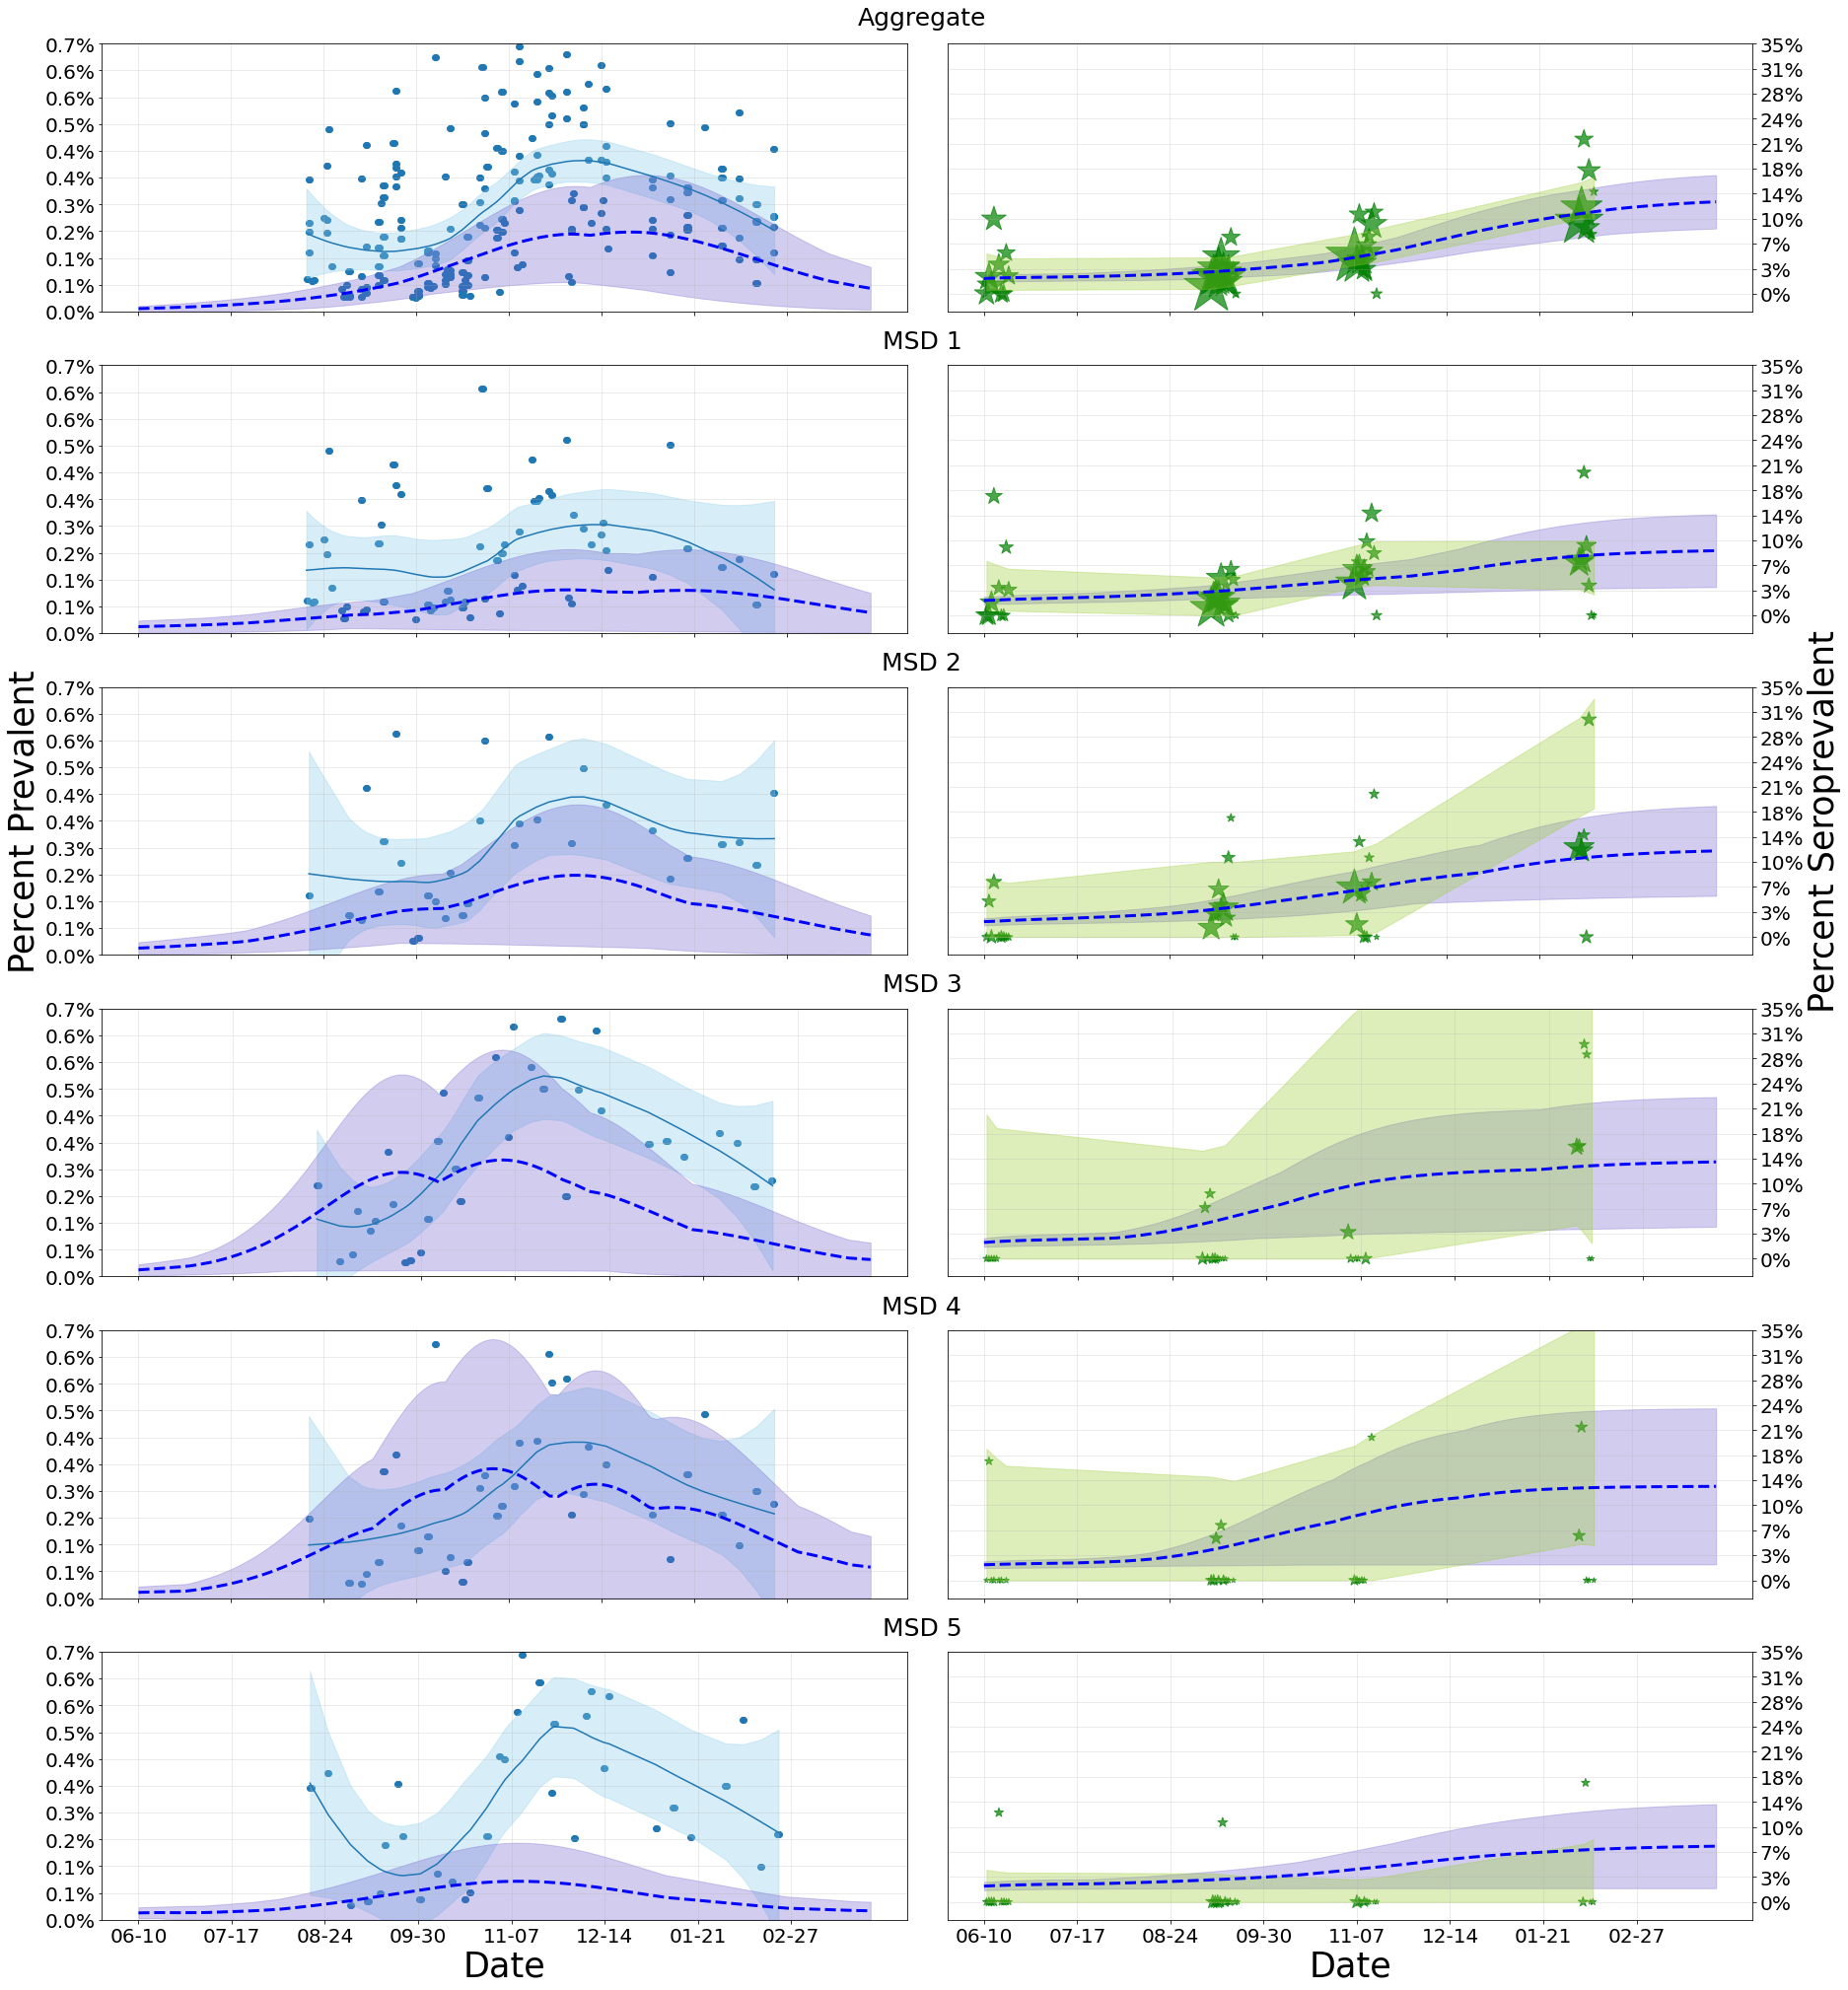

In [10]:
fig, ax = plt.subplots(6, 2, figsize=(30,35))

for i in range(0,6):
    if i==0:
        df_prev = pd.read_csv(path+"I_estimate_msd_agg_w1-4.csv")
        df_seroprev = pd.read_csv(path+"T_estimate_msd_agg_w1-4.csv")
        df_inc = pd.read_csv(path+"dS_estimate_msd_agg_w1-4.csv")
        df_point = pd.read_csv(path+"data_msd_agg_w1-4.csv")
        pass
    else:
        df_prev = pd.read_csv(path+"I_estimate_msd_0"+str(i)+"_w1-4.csv")
        df_seroprev = pd.read_csv(path+"T_estimate_msd_0"+str(i)+"_w1-4.csv")
        df_inc = pd.read_csv(path+"dS_estimate_msd_0"+str(i)+"_w1-4.csv")
        df_point = pd.read_csv(path+"data_msd_0"+str(i)+"_w1-4.csv")
    
    # plot from water data
    df_water = pd.read_csv("../data/raw/WW_data.csv")
    if i!=0:
        df_water = df_water[(df_water.Site=='MSD0'+str(i)) & (df_water.QDI_n1==1)]
    else:
        df_water = df_water[df_water.QDI_n1==1]
    
    df_water.Date = [datetime.datetime.strptime(dt, "%m/%d/%y").strftime("%Y-%m-%d") for dt in df_water.Date]
    df_water = df_prev.merge(df_water, how="inner", left_on="date", right_on="Date")[["time", "Date", "avg_n1", "sd_n1"]]
    df_water = df_water[df_water.avg_n1/water_div<0.007]
    x = list(df_water.time)
    y = list(df_water.avg_n1/water_div)

    water_smoothed = loess(x, y)
    water_smoothed.fit()
    pred = water_smoothed.predict(x, stderror=True)
    conf = pred.confidence(alpha=0.0001)
    lowess = list(pred.values)
    ll = conf.lower
    ul = conf.upper

    ax[i][0].scatter(x, y)
    ax[i][0].plot(x, lowess)
    ax[i][0].fill_between(x, ll, ul, alpha=.33, color='skyblue')
    
    # Indicence plot
#     ax[i][0].plot(df_inc.time, list(df_inc.pseudo_med),
#                    'r--', linewidth=3)
#     ax[i][0].fill_between(df_inc.time, list(df_inc.bottom), list(df_inc.top),
#                            alpha=0.3, color='red')
    
    # prevalence plot
    ax[i][0].plot(df_prev.time, list(df_prev.pseudo_med),
                   'b--', linewidth=3)
    ax[i][0].fill_between(df_prev.time, list(df_prev.bottom), list(df_prev.top),
                           alpha=0.3, color='slateblue')
    
    # seroprevalence plot
    ax[i][1].plot(df_seroprev.time, list(df_seroprev.pseudo_med),
                   'b--', linewidth=3)
    ax[i][1].fill_between(df_seroprev.time, list(df_seroprev.bottom), list(df_seroprev.top),
                           alpha=0.3, color='slateblue')
    # testing data (stars)
    star_sizes = [(size+2)*10 for size in df_point.num_antibody_total]
    ax[i][1].scatter(df_point.time_point, df_point.percent_positive, s=star_sizes,
                      color='g', marker='*', alpha=0.7)
    
    # testing data ribbon
    x = list(df_point.time_point)
    y = list(df_point.percent_positive)
    
    if i==2:
        cases_smoothed = loess(x, y, span=0.9)
    else:
        cases_smoothed = loess(x, y, span=0.9)
    cases_smoothed.fit()
    pred = cases_smoothed.predict(x, stderror=True)
    conf = pred.confidence()
    lowess = pred.values
    ll = [ max(y_ll, 0) for y_ll in conf.lower]
    ul = conf.upper

    ax[i][1].fill_between(x, ll, ul, alpha=.33, color='yellowgreen')
    
    # formatting
    ax[i][0].set_ylim((0, max_y1))
    ax[i][1].set_ylim((-0.025, max_y2))
    
    ax[i][0].grid(alpha=0.3)
    ax[i][1].grid(alpha=0.3)
    ax[i][0].margins(0.05)
    ax[i][1].margins(0.05)
    ax[i][0].set_xticks(xtick_vals)  
    ax[i][0].set_xticklabels([date[5:] for date in list(df_prev.date)[::xticks_span]], fontsize=20)
    ax[i][1].set_xticks(xtick_vals)  
    ax[i][1].set_xticklabels([date[5:] for date in list(df_prev.date)[::xticks_span]], fontsize=20)
    ax[i][0].set_yticks(list(np.arange(0, max_y1, max_y1/10))+[max_y1])
    ax[i][1].set_yticks(list(np.arange(0, max_y2, max_y2/10))+[max_y2])
    ax[i][0].set_yticklabels(['{:.1f}%'.format(x*100) for x in ax[i][0].get_yticks()], fontsize=20)
    ax[i][1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[i][1].get_yticks()], fontsize=20)
    
    ax[i][1].yaxis.set_label_position("right")
    ax[i][1].yaxis.tick_right()
    
    if i!=5:
        ax[i][0].axes.xaxis.set_ticklabels([])
        ax[i][1].axes.xaxis.set_ticklabels([])
    
ax[5][0].set_xlabel("Date", fontsize=35)
ax[5][1].set_xlabel("Date", fontsize=35)
ax[2][0].set_ylabel("Percent Prevalent", fontsize=35)
ax[2][1].set_ylabel("Percent Seroprevalent", fontsize=35)

plt.figtext(0.51,0.895, "Aggregate", ha="center", va="top", fontsize=25)
for i in range(5):
    plt.figtext(0.51,0.765-0.1295*i, "MSD "+str(i+1), ha="center", va="top", fontsize=25)
       
plt.subplots_adjust(wspace=0.05)
plt.savefig('prev_seroprev_zones_1-5_inc.png')
plt.show()

In [42]:
#from svgpath2mpl import parse_path

In [69]:
from matplotlib.markers import MarkerStyle

In [43]:
covid = parse_path("""m 739.01202,391.98936 c 13,26 13,57 9,85 -6,27 -18,52 -35,68 -21,20 -50,23 -77,18 -15,-4 -28,-12 -39,-23 -18,-17 -30,-40 -36,-67 -4,-20 -4,-41 0,-60 l 6,-21 z m -302,-1 c 2,3 6,20 7,29 5,28 1,57 -11,83 -15,30 -41,52 -72,60 -29,7 -57,0 -82,-15 -26,-17 -45,-49 -50,-82 -2,-12 -2,-33 0,-45 1,-10 5,-26 8,-30 z M 487.15488,66.132209 c 121,21 194,115.000001 212,233.000001 l 0,8 25,1 1,18 -481,0 c -6,-13 -10,-27 -13,-41 -13,-94 38,-146 114,-193.000001 45,-23 93,-29 142,-26 z m -47,18 c -52,6 -98,28.000001 -138,62.000001 -28,25 -46,56 -51,87 -4,20 -1,57 5,70 l 423,1 c 2,-56 -39,-118 -74,-157 -31,-34 -72,-54.000001 -116,-63.000001 -11,-2 -38,-2 -49,0 z m 138,324.000001 c -5,6 -6,40 -2,58 3,16 4,16 10,10 14,-14 38,-14 52,0 15,18 12,41 -6,55 -3,3 -5,5 -5,6 1,4 22,8 34,7 42,-4 57.6,-40 66.2,-77 3,-17 1,-53 -4,-59 l -145.2,0 z m -331,-1 c -4,5 -5,34 -4,50 2,14 6,24 8,24 1,0 3,-2 6,-5 17,-17 47,-13 58,9 7,16 4,31 -8,43 -4,4 -7,8 -7,9 0,0 4,2 8,3 51,17 105,-20 115,-80 3,-15 0,-43 -3,-53 z m 61,-266 c 0,0 46,-40 105,-53.000001 66,-15 114,7 114,7 0,0 -14,76.000001 -93,95.000001 -76,18 -126,-49 -126,-49 z""")
covid.vertices -= covid.vertices.mean(axis=0)


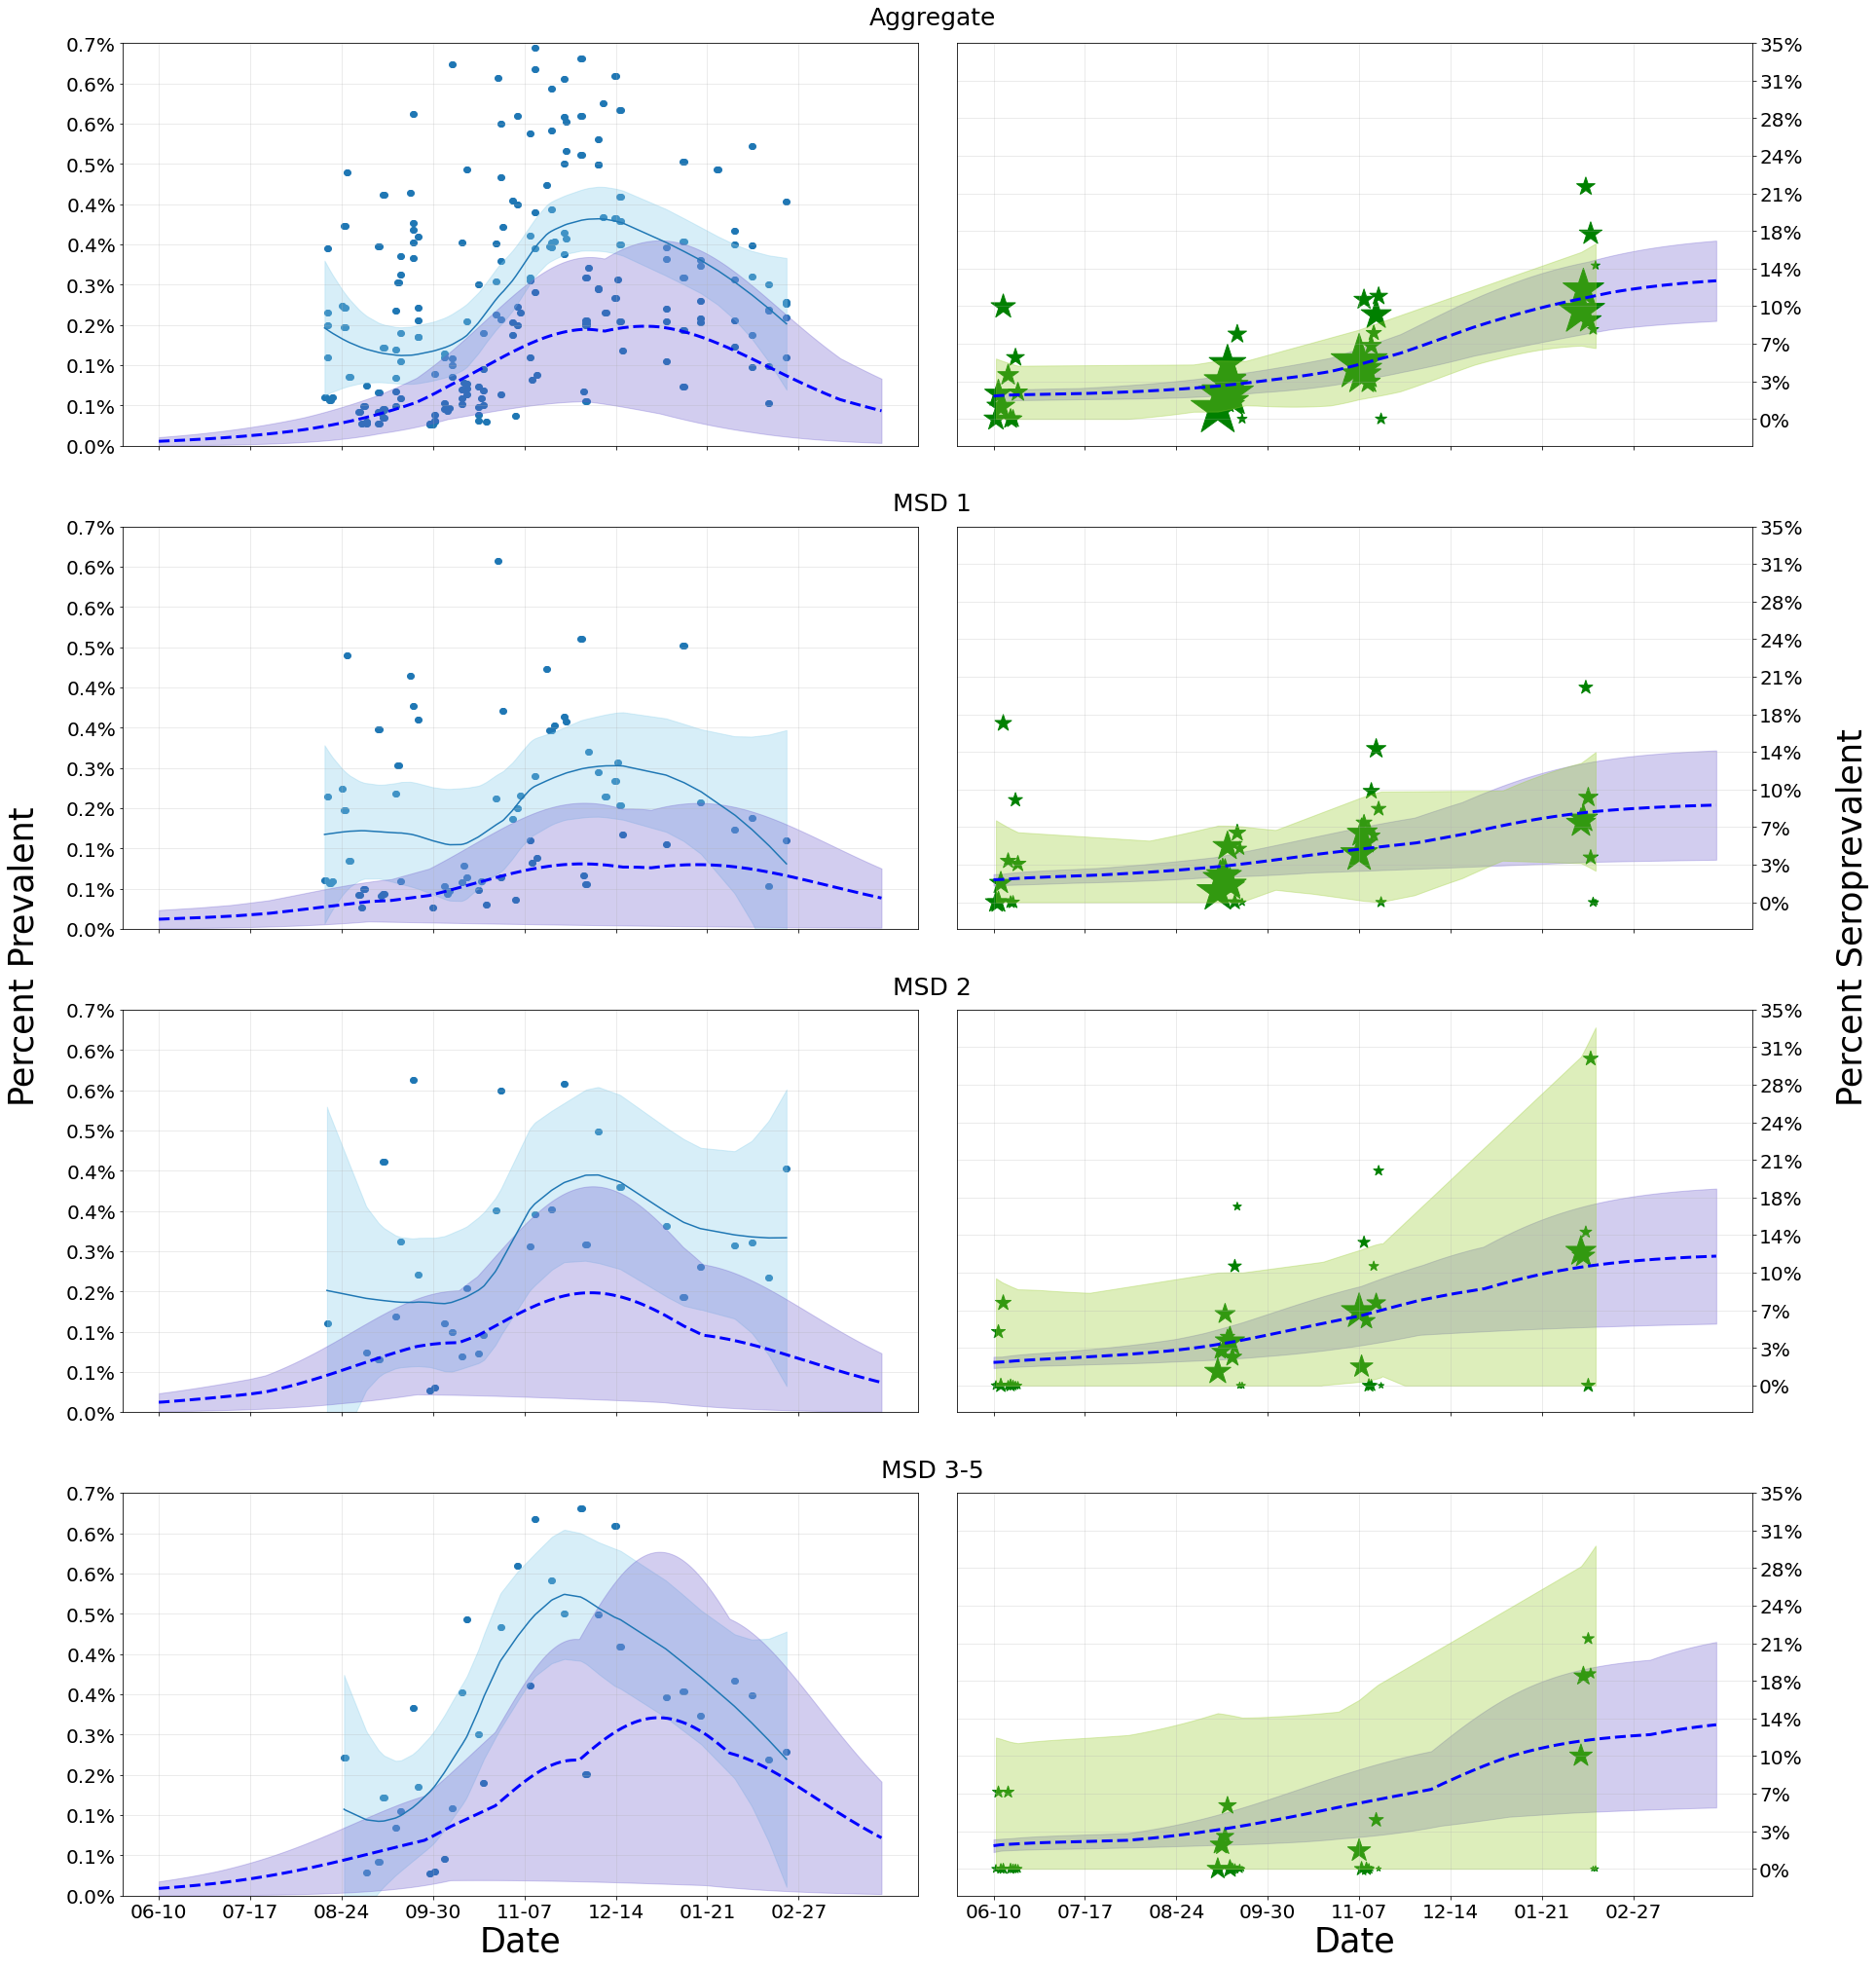

In [79]:
fig, ax = plt.subplots(4, 2, figsize=(30,35))

for i in range(0,4):
    if i==0:
        df_prev = pd.read_csv(path+"I_estimate_msd_agg_w1-4.csv")
        df_seroprev = pd.read_csv(path+"T_estimate_msd_agg_w1-4.csv")
        df_inc = pd.read_csv(path+"dS_estimate_msd_agg_w1-4.csv")
        df_point = pd.read_csv(path+"data_msd_agg_w1-4.csv")
        pass
    elif i==3:
        path2 = "../results/temp2/"
        df_prev = pd.read_csv(path2+"I_estimate_msd_03-05_w1-4.csv")       
        df_seroprev = pd.read_csv(path2+"T_estimate_msd_03-05_w1-4.csv")
        df_point = pd.read_csv(path2+"data_msd_03-05_w1-4.csv")
        df_point.percent_positive = df_point.num_antibody_positive/df_point.num_antibody_total
        
    else:
        df_prev = pd.read_csv(path+"I_estimate_msd_0"+str(i)+"_w1-4.csv")
        df_seroprev = pd.read_csv(path+"T_estimate_msd_0"+str(i)+"_w1-4.csv")
        df_inc = pd.read_csv(path+"dS_estimate_msd_0"+str(i)+"_w1-4.csv")
        df_point = pd.read_csv(path+"data_msd_0"+str(i)+"_w1-4.csv")
    
    # ----------------------- plot from water data ----------------------- 
    df_water = pd.read_csv("../data/raw/WW_data.csv")
    if i!=0:
        df_water = df_water[(df_water.Site=='MSD0'+str(i)) & (df_water.QDI_n1==1)]
    else:
        df_water = df_water[df_water.QDI_n1==1]
    
    df_water.Date = [datetime.datetime.strptime(dt, "%m/%d/%y").strftime("%Y-%m-%d") for dt in df_water.Date]
    df_water = df_prev.merge(df_water, how="inner", left_on="date", right_on="Date")[["time", "Date", "avg_n1", "sd_n1"]]
    df_water = df_water[df_water.avg_n1/water_div<0.007]
    x = list(df_water.time)
    y = list(df_water.avg_n1/water_div)

    water_smoothed = loess(x, y)
    water_smoothed.fit()
    pred = water_smoothed.predict(x, stderror=True)
    conf = pred.confidence(alpha=0.0001)
    lowess = list(pred.values)
    ll = conf.lower
    ul = conf.upper

    ax[i][0].scatter(x, y)
    ax[i][0].plot(x, lowess)
    ax[i][0].fill_between(x, ll, ul, alpha=.33, color='skyblue')
    
    # Indicence plot
#     ax[i][0].plot(df_inc.time, list(df_inc.pseudo_med),
#                    'r--', linewidth=3)
#     ax[i][0].fill_between(df_inc.time, list(df_inc.bottom), list(df_inc.top),
#                            alpha=0.3, color='red')
    
    # ----------------------- prevalence plot ----------------------- 
    ax[i][0].plot(df_prev.time, list(df_prev.pseudo_med),
                   'b--', linewidth=3)
    ax[i][0].fill_between(df_prev.time, list(df_prev.bottom), list(df_prev.top),
                           alpha=0.3, color='slateblue')
    
    # ----------------------- seroprevalence plot ----------------------- 
    ax[i][1].plot(df_seroprev.time, list(df_seroprev.pseudo_med),
                   'b--', linewidth=3)
    ax[i][1].fill_between(df_seroprev.time, list(df_seroprev.bottom), list(df_seroprev.top),
                           alpha=0.3, color='slateblue')
    # ----------------------- testing data (stars) ----------------------- 
    star_sizes = [(size+2)*10 for size in df_point.num_antibody_total]
#     ax[i][1].scatter(df_point.time_point, df_point.percent_positive, s=star_sizes,
#                       color='g', marker=u'$\u2055$', alpha=0.7)
    ax[i][1].scatter(df_point.time_point, df_point.percent_positive, s=star_sizes,
                      color='g', marker='*', alpha=1)
    
    # ----------------------- testing data ribbon ----------------------- 
    x = list(df_point.time_point)
    y = list(df_point.percent_positive)
    
    cases_smoothed = loess(x, y, span=0.95)
    cases_smoothed.fit()
    pred = cases_smoothed.predict(x, stderror=True)
    conf = pred.confidence()
    lowess = pred.values
    ll = conf.lower
    ul = conf.upper
    # reparametrization
    x_time = df_seroprev.time
    y = list(df_seroprev.pseudo_med)
    x2 = list(np.arange(min(x), max(x)+0.1, 0.5))
    ll2 = []
    ul2 = []
    for j in range(1, len(ll)):
        x_temp = np.arange(x[j-1], x[j]+0.1, 0.5)
        y_ll = np.linspace(ll[j-1], ll[j], len(x_temp))
        y_ul = np.linspace(ul[j-1], ul[j], len(x_temp))
        ll2 += list(y_ll[:-1])
        ul2 += list(y_ul[:-1])
    ll2 += [ll[-1]]     
    ul2 += [ul[-1]]
    y_pred = [ y[i] for i in range(len(x_time)) if x_time[i] in x2]
    ll = [max(0, min(ll2[i], 2*y_pred[i]-ul2[i])) for i in range(len(ll2))]
    ul = [max(ul2[i], 2*y_pred[i]-ll2[i]) for i in range(len(ul2))]
    
    ax[i][1].fill_between(x2, ll, ul, alpha=.33, color='yellowgreen')
    
    # ----------------------- formatting ----------------------- 
    ax[i][0].set_ylim((0, max_y1))
    ax[i][1].set_ylim((-0.025, max_y2))
    
    ax[i][0].grid(alpha=0.3)
    ax[i][1].grid(alpha=0.3)
    ax[i][0].margins(0.05)
    ax[i][1].margins(0.05)
    ax[i][0].set_xticks(xtick_vals)  
    ax[i][0].set_xticklabels([date[5:] for date in list(df_prev.date)[::xticks_span]], fontsize=20)
    ax[i][1].set_xticks(xtick_vals)  
    ax[i][1].set_xticklabels([date[5:] for date in list(df_prev.date)[::xticks_span]], fontsize=20)
    ax[i][0].set_yticks(list(np.arange(0, max_y1, max_y1/10))+[max_y1])
    ax[i][1].set_yticks(list(np.arange(0, max_y2, max_y2/10))+[max_y2])
    ax[i][0].set_yticklabels(['{:.1f}%'.format(x*100) for x in ax[i][0].get_yticks()], fontsize=20)
    ax[i][1].set_yticklabels(['{:.0f}%'.format(x*100) for x in ax[i][1].get_yticks()], fontsize=20)
    
    ax[i][1].yaxis.set_label_position("right")
    ax[i][1].yaxis.tick_right()
    
    if i!=3:
        ax[i][0].axes.xaxis.set_ticklabels([])
        ax[i][1].axes.xaxis.set_ticklabels([])
    
ax[3][0].set_xlabel("Date", fontsize=35)
ax[3][1].set_xlabel("Date", fontsize=35)
plt.figtext(0.07, 0.45, "Percent Prevalent", fontsize=35, rotation=90)
plt.figtext(0.94, 0.45, "Percent Seroprevalent", fontsize=35, rotation=90)

plt.figtext(0.51,0.895, "Aggregate", ha="center", va="top", fontsize=25)
for i in range(3):
    ind = str(i+1) if i!=2 else "3-5"
    plt.figtext(0.51,0.697-0.197*i, "MSD "+ind, ha="center", va="top", fontsize=25)
    
plt.subplots_adjust(wspace=0.05)
#plt.savefig('prev_seroprev_zones_1-5_merge.png')
plt.show()

# Dividing by PMMoV

In [7]:
df_water = pd.read_csv("../data/raw/WW_data.csv")
df_water.head()

Sample_No   Site     Date      avg_n1      sd_n1  QDI_n1     avg_PMMoV  \
0        181  MSD02  8/18/20   32.419594   7.093643       1  2.659409e+05   
1        184  MSD03  8/18/20  174.015076  14.898330       1  1.386870e+06   
2        185  MSD04  8/18/20   43.853963   4.851219       1  3.181272e+05   
3        186  MSD05  8/18/20   72.208670  10.328528       1  3.594010e+05   
4      44060  MSD01  8/17/20   17.743916   5.640858       1  1.016735e+05   

      sd_PMMoV  QDI_PMMoV  avg_CrAssphage  sd_CrAssphage  QDI_CrAssphage  
0  131763.7062          1    8.781538e+05   2.719419e+05               1  
1  1303893.285          1    3.750986e+06   1.594845e+06               1  
2  84214.55362          1    1.086837e+06   3.696691e+05               1  
3  50673.06368          1    8.221564e+06   3.900455e+06               1  
4  60968.12469          1    6.199099e+04   3.280031e+04               1

In [8]:
x = df_water.avg_n1/df_water.avg_PMMoV

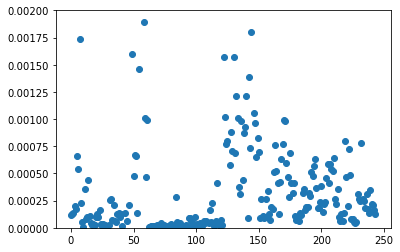

In [14]:
plt.scatter(range(len(x)), x)
plt.ylim((0, 0.002))
plt.show()